# Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Data Overview](#data)
- [Cleaning Data](#cleaning)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - How long was the experiment run for?](#exp_time)
- [Conclusions](#conclusions)

***
<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The company has developed a new web page in order to try and increase the number of users who "convert", meaning the number of users who decide to pay for the company's product. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

***
<a id='data'></a>
### Data Overview
To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, we'll read in the **ab_data.csv** data and store it in **df**. 

In [2]:
# Let's read in the dataset and take a look at the top few rows here
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


This dataset contains 5 columns, with the following detail:
- user_id: The ID of user who participated in the experiment.
- timestamp: The time at which the user accessed the website page.
- group: Whether the user was part of the control (needs to see the old page) or treatment group (needs to see the new page).
- landing page: Whether the user saw the website's old page or new page.
- converted: Whether the user converted or not (1 being that they converted and 0 being that they did not converted).

***
<a id='cleaning'></a>
### Cleaning Data

`1.` First, let's check the following:<br><br>
a. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

b. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

c. The proportion of users converted. 

In [5]:
# Considering duplicated users
df.converted.mean()

0.11965919355605512

`2.` Then, let's check for missing values and mismatching rows:
<br><br>
a. Do any of the rows have missing values?

In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
pd.isnull(df).sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No, there are no rows with missing values in this dataframe.

b. The number of times the **new_page** and **treatment** don't match.

In [8]:
df.query('(group=="treatment" and landing_page=="old_page") or (group=="control" and landing_page=="new_page")').shape[0]

3893

`3.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So, we will remove these unmatching rows and store the new dataframe in **df2**.

In [9]:
# Removing rows where the landing_page and group columns don't match
index_names = df.query('(group=="treatment" and landing_page=="old_page") or (group=="control" and landing_page=="new_page")').index
df2 = df.drop(index=index_names)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Checking the shape of our updated dataframe
df2.shape

(290585, 5)

`4.` Afterwards, let's check for duplicated rows:

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeated **user_id**? 

In [14]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Above we can see that:
- The user_id for the non-unique id in df2: 773192
- The landing_page for the non-unique id: new_page
- The group for the non-unique id: treatment
- The value of converted column for the non-unique id: 0

Since, there is consistency with this non-unique id, we can just choose either and remove. We shouldn't be counting the same user more than once.

d. We'll remove **one** of the rows with a duplicated **user_id**, but keep the dataframe as **df2**.

In [15]:
# Removing one of the duplicated user_id
df2 = df2.drop(df2[df2.user_id.duplicated()].index)

In [16]:
# Let's check that duplicated user_id row was correctly removed
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


In [17]:
# Let's check the shape of the updated dataframe
df2.shape

(290584, 5)

***
<a id='probability'></a>
### Part I - Probability

We'll use **df2** in the cells below to answer the following questions:

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the **control** group, what is the probability they converted?

In [19]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the **treatment** group, what is the probability they converted?

In [20]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(df2['landing_page']=="new_page").mean()

0.50006194422266881

In the observed data, the proportion of conversion in the control group is higher than in the treatment group. However, this is not sufficient evidence to conclude that the old page leads to more conversions, yet. We need to perform a Hypothesis Test to have statistically significance in our conclusions.

***
<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we'll make the decision just based on all the data provided.  If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, we'll state our hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages, respectively:

$$H_0 : p_{old} - p_{new} >= 0$$
$$H_1 : p_{old} - p_{new} < 0$$

#### `1.` *First approach for A/B Test*

We'll assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we'll assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We'll use a sample size for each page equal to the ones in **ab_data.csv**, and we'll perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
pnew = df2.converted.mean()
print(pnew)

0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null?

In [23]:
pold = df2.converted.mean()
print(pold)

0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2.query('group=="treatment"').shape[0]
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2.query('group=="control"').shape[0]
print(n_old)

145274


Here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

e. We'll simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null, and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-pnew, pnew])

f. We'll simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null, and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-pold, pold])

g. Let's find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0011307233438100084

h. Let's create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above, and store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for i in range(10000):
    new_page_c = np.random.choice([0,1], size=n_new, p=[1-pnew, pnew])
    old_page_c = np.random.choice([0,1], size=n_old, p=[1-pold, pold])
    p_diffs.append(new_page_c.mean() - old_page_c.mean())

i. Let's plot a histogram of the **p_diffs**.

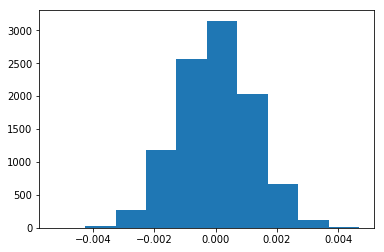

In [30]:
plt.hist(p_diffs);

This plot looks like a normal distribution, as expected from the Central Limit Theorem.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# Calculating the actual difference observed in df2
obs_diff = df2.query('group=="treatment"').converted.mean() - df2.query('group=="control"').converted.mean()
print(obs_diff)

-0.00157823898536


In [32]:
# Calculating the p-value or 
# proportion of p_diffs that is greater than the actual difference observed
(p_diffs > obs_diff).mean()

0.90480000000000005

Considering a Type I error rate of 5%, since our p-value (0.9) is larger than 0.05, we fail to reject the Null.<br>
Therefore, we can conclude that the old page's conversion rate is equal or greater than the new page's.

#### `2.`  *Second approach for A/B Test*

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 
<br><br>
a. Bellow, we will calculate the number of conversions for each page, as well as the number of individuals who received each page.

In [33]:
# Importing necessary library
import statsmodels.api as sm

# Calculating the number of conversions for each page
convert_old = sum((df2.group=='control')&(df2.converted==1))
convert_new = sum((df2.group=='treatment')&(df2.converted==1))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
# Printing the number of conversions for each page
print(convert_old)
print(convert_new)

17489
17264


In [35]:
# Printing the number of individuals who received each page
print(n_old)
print(n_new)

145274
145310


b. Let's use **stats.proportions_ztest** to compute the test statistic and p-value. 

In [36]:
# Calculating z-score and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

In [37]:
# Printing z-score and p-value
print(z_score)
print(p_value)

-1.31092419842
0.905058312759


c. Let's calculate the critical z-score.

In [38]:
# Importing necessary library
from scipy.stats import norm

# Calculating the critical z-score
critical_z = norm.ppf(1-(0.05/2))
print(critical_z)

1.95996398454


Since our results are:<br>
- zscore (-1.31) is between -1.96 and 1.96
- p-value (0.9) is larger than 0.05

Considering a Type I error rate of 5%, we fail to reject the null.<br>
Therefore, we can conclude that the old page's conversion rate is equal or greater than the new page's.<br>
This result agrees with the findings in the First Approach of A/B Test performed before.

#### `3.` *Third Approach for A/B Test*
We are going to do a last approach to analyze our results through Hypothesis Testing.

In [39]:
# Our observed difference in proportions of conversions
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
print(obs_diff)

-0.00157823898536


In [40]:
# Let's create sampling distribution for difference in proportions of conversions
# of new page and old page, with boostrapping
diffs = []
for _ in range(10000):
    b_samp = df2.sample(df2.shape[0], replace=True)
    control_c = b_samp.query('group == "control"').converted.mean()
    experiment_c = b_samp.query('group == "treatment"').converted.mean()
    diffs.append(experiment_c - control_c)

In [41]:
# Let's convert to numpy array
diffs = np.array(diffs)

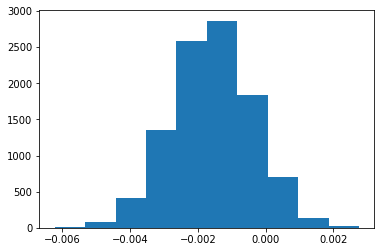

In [42]:
# Let's plot this sampling distribution
plt.hist(diffs);

In [43]:
# Let's create distribution under the null hypothesis
null_vals = np.random.normal(loc=0, scale=diffs.std(), size=diffs.size)

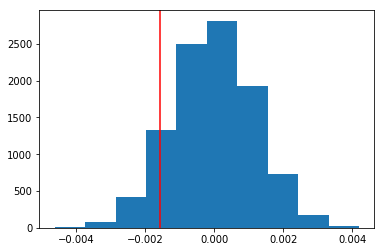

In [44]:
# Let's plot null distribution
plt.hist(null_vals);

# Let's plot line for observed statistic
plt.axvline(x=obs_diff, color="red");

In [45]:
# Let's compute our p-value
(null_vals > obs_diff).mean()

0.90720000000000001

Considering a Type I error rate of 5%, since our p-value (0.9) is larger than 0.05, we fail to reject the Null.
<br>
Therefore, we can conclude that the old page's conversion rate is equal or greater than the new page's.<br>
This result also agrees with the First and Second approach of A/B Test performed before.

***
<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result we achieved in the A/B test in Part II above can also be achieved by performing a regression.<br><br> 

We will perform a Logistic Regression, because the target or predicted variable is categorical (a conversion or no conversion).

#### `1.` *First model - explanatory variable: page*

The goal is to use **statsmodels** to fit a logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. 
<br><br>
a. First, let's to create in **df2** a column for the **intercept**, and create a dummy variable column for which page each user received. Afterwards, we'll add an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [46]:
# Creating in df2 a column for the intercept
df2['intercept'] = 1

In [47]:
# Creating a dummy variable column for which page each user received
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

In [48]:
# Creating ab_page column
df2['ab_page'] = df2['treatment']

In [49]:
# Dropping control and treatment columns
df2.drop(columns=['control','treatment'], inplace=True)

In [50]:
# Showing first lines of df2
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


b. We'll use **statsmodels** to instantiate the regression model on the two columns we created in part (a), and then fit the model using these two columns to predict whether or not an individual converts. 

In [51]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Let's provide the summary of the model.

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:11:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with **ab_page** is 0.190. This p-value is associated with the following two-sided test:<br><br>
$$H_0: \beta_{1} = 0$$
$$H_1: \beta_{1} \neq 0$$
<br>
Being $\beta_{1}$ the coefficient of **ab_page** in the Logistic Regression equation to predict conversion.<Br>
Since this p-value (0.190) is higher than 0.05, with a Type I error rate of 5%, we fail to reject the Null. Therefore, the page (old or new) a user sees is not statistically significant for predicting if a user converts or not.
<br><br>
On the other side, this p-value is obviouly different than the one in Part II because they belong to different Hypothesis Testing. However, the conclusions in both are linked: 
- In part II, we concluded that the new page does not *increase* (alternative hypothesis with one-tailed test) conversion rate significantly.
- In this part, we conclude that the page (new or old) does not *change* (alternative hypothesis with two-tailed test) the conversion rate significantly.

#### *Second model - explanatory variables: page and country*

Now, we are considering other things that might influence whether or not an individual converts. It is a good idea to consider other factors to add into the regression model in order to check if they are statistical or practical significants, and to obtain the best model for prediction. Also, adding subgroups among data could help us detect any Simpson's Paradox.<br><br>
However, there are disadvantages of adding additional terms into the regression model: we would need to check if there is multicolinearity between variables, we could have correlated errors, etc.

So along with testing if the conversion rate changes for different pages, we'll also add an effect based on which country a user lives in. For that, we will include the data of users' country of **countries.csv** into our analysis.

In [53]:
# Reading in the countries.csv dataset 
df3 = pd.read_csv('countries.csv')

# Showing the first lines of this countries dataset
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [54]:
# Checking df3 shape
df3.shape

(290584, 2)

In [55]:
# Checking df2 shape once again
df2.shape

(290584, 7)

In [56]:
# Checking how many unique users are in the df3
df3.user_id.nunique()

290584

In [57]:
# Checking how many unique users are in the df2 once again
df2.user_id.nunique()

290584

It looks like there are as many **user_id** and unique **user_id**s in **df3** as in **df2**.

In [58]:
# Joining df2 and df3 tables into df4
df4 = df2.join(df3.set_index('user_id'), on='user_id', how='inner')

In [59]:
# Checking first rows of df4 table
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [60]:
# Checking there are not missing values in df4
df4.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [61]:
# Checking the shape of df4 table
df4.shape

(290584, 8)

In [62]:
# Checking the conversion rate for each country
df4.groupby('country').converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

It seems the conversion rate it's very similar between countries.

In [63]:
# Creating dummy variables for these country columns
df4[['CA','UK','US']] = pd.get_dummies(df4['country'])

Before fitting our regression model, let's check there is not multicollinearity between our explanatory variables.

In [64]:
# Importing library
import seaborn as sb

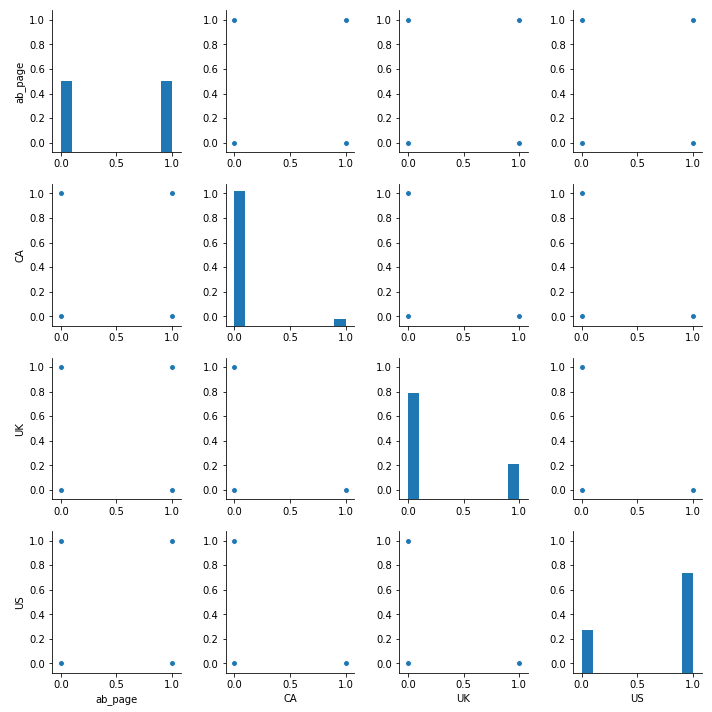

In [65]:
# We use seaborn to look at pairwise relationships for all of the explanatory variables 
sb.pairplot(df4[['ab_page','CA','UK','US']]);

From the pairplot above, there does not seem to be a linear correlation between any of the explanatory variables. But let's check VIF (Variance Inflation Factors) just in case.

In [66]:
# Importing necessary libraries
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF, considering that CA will be our baseline
y, X = dmatrices('converted ~ ab_page + UK + US', df4, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [67]:
# Displaying VIF
vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,ab_page
2,4.502236,UK
3,4.502223,US


Since the VIFs of all the explanatory variables (**ab_page** and **country** levels) are bellow 5, we do not have a multicollinearity problem, and we can keep all of these variables for our model. Now, let's fit our model.

In [68]:
# Fitting a Logistic Regression considering page and country
# considering CA as baseline
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK','US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        00:12:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Since the p-values for all the independent variables (**ab_page, UK** and **US**) are higher than 0.05, with a Type I error rate of 5%, neither of them is statistically significant for predicting if a user converts or not. Therefore, neither the page a user sees (old or new) or their country is statistically significant for predicting if a user converts or not. 

#### *Third model - explanatory variables: page, country and interaction between page and country*

Though we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there is any significant effects on conversion.  Let's create the necessary additional columns, and fit the new model.

In [69]:
# Let's create the interaction columns
df4['ab_page_US'] = df4['ab_page']*df4['UK']
df4['ab_page_UK'] = df4['ab_page']*df4['US']

In [70]:
# Fitting a Logistic Regression considering page, country, and the interaction between page and country
# considering CA as baseline
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK','US', 'ab_page_US', 'ab_page_UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        00:12:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page_US     0.0783      0.057      1.378      0.168      -0.033       0.190
ab_page_UK     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Since the p-values for all the independent variables (**ab_page, UK, US, ab_page_UK** and **ab_page_US**) are higher than 0.05, with a Type I error rate of 5%, neither of them is statistically significant for predicting if a user converts or not. Therefore, neither the page a user sees (old or new) nor their country nor the interaction between page and country is statistically significant for predicting if a user converts or not. 

#### *Fourth model - explanatory variables: weekday and weekend*

From the dataframe, we have that the timestamp column contains the time at which the user accessed the page. We will fit a Logistic Regression to see if the day someone logged into the page predicts the conversion rate.

In [71]:
# Checking df4 data types
df4.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
ab_page          uint8
country         object
CA               uint8
UK               uint8
US               uint8
ab_page_US       uint8
ab_page_UK       uint8
dtype: object

In [72]:
# Checking first rows of df4
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_US,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [73]:
# Changing type of timestamp
df4.timestamp = pd.to_datetime(df4.timestamp, format='%Y-%m-%d %H:%M:%S.%f')

In [74]:
# Creating a column with the day of the week
df4['dayofweek'] = df4.timestamp.dt.dayofweek

In [75]:
# Creating a weekend column, with 1 for weekend and 0 for weekday
df4['weekend'] = ((df4.dayofweek)//5 == 1).astype(float).astype(int)

In [76]:
# Checking how our updated df4 looks
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_US,ab_page_UK,dayofweek,weekend
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,5,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,3,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1,2,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1,6,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,5,1


It's worth noting that we did not create a "weekday" column as it will be our baseline.

In [77]:
# Fitting a Logistic Regression, considering weekday as baseline
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'weekend']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               1.227e-08
Time:                        00:12:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.9593
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9964      0.007   -297.555      0.000      -2.010      -1.983
weekend        0.0007      0.013      0.051      0.959      -0.024       0.026
==============================================================================
"""

Since the p-value of **weekend** (0.959) is higher than 0.05, with a Type I error rate of 5% we fail to reject the Null. <br>
Therefore, if a user visited our website on weekend or weekday is not statistically significant for predicting if a user converts or not.

***
<a id='exp_time'></a>
### Part IV - How long was the experiment run for?

In [78]:
# Duration of this experiment
max(df4.timestamp)-min(df4.timestamp)

Timedelta('21 days 23:59:49.081927')

The experiment was run for aprox. 22 days.

***
<a id='conclusions'></a>
## Conclusions

The final conclusions of this project are the following:
- There are a total of 290,584 unique users who participated in the experiment. 12% of them converted, regardless  of the page they received.
- These participants had an equal probability of getting either the old or new page.
- Our participants belong to three countries: Canada, UK and USA. And their conversion rate is similar regardless of their nationality (11-12%).
- With a Type I error rate of 5%, the old page's conversion rate is equal or greater than the new page's, so we do not advice to change the page based only on expecting a higher conversion rate.
- If there is another reasoning behind the change of page (re-branding, security, etc), further analysis should be performed. 
- The page each user received (old or new) is not statistically significant in predicting whether or not an individual converts.
- Similarly the user's country, the interaction between page and country, and whether a user visitted the page on a  weekend/weekday are not statistically significants in predicting conversion rate.

Limitations of this Project:
- The scope of this project does not involve Machine Learning as its focus is more on statistics.
- There is not information about the time spent on the website by a user before converting, so the analysis cannot go further in that aspect.
- There is not more information about the user besides its country (like gender, age, source of visit, etc.), so the analysis cannot go further in that aspect.
- Other factors involved in the desire of updating the website are not disclosed (p.e: re-branding, security, etc), so the analysis cannot provide further recommendation in that aspect.
- Since the users' information is limited (p.e: there is not information about how long have they been users of our page) we cannot address problems like novelty effect or change aversion, but it is something to consider given the short span of time of the experiment (22 days).
- We will not run a hypothesis test continuously as each observation was observed, as it is out of the scope for this project.

References:
- Pandas documentation: https://pandas.pydata.org/pandas-docs/stable/reference/
- Ztest information: https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/
- Dropping values in Pandas: https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
- Markdown for Jupyter Notebook: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- Creating a weekend column: https://stackoverflow.com/questions/32278728/convert-dataframe-date-row-to-a-weekend-not-weekend-value

***
## Submitting Project

In [79]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0